In [73]:
import warnings
warnings.filterwarnings("ignore")

from dateutil.parser import parse 

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

In [6]:
# load the data
df = pd.read_csv("ElectricalProduction.csv")

#rename columns
df = df.rename(columns={"IPG2211A2N":"EC", "DATE":"Date"})

#convert to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce',infer_datetime_format=True)

#set index
df = df.set_index('Date')

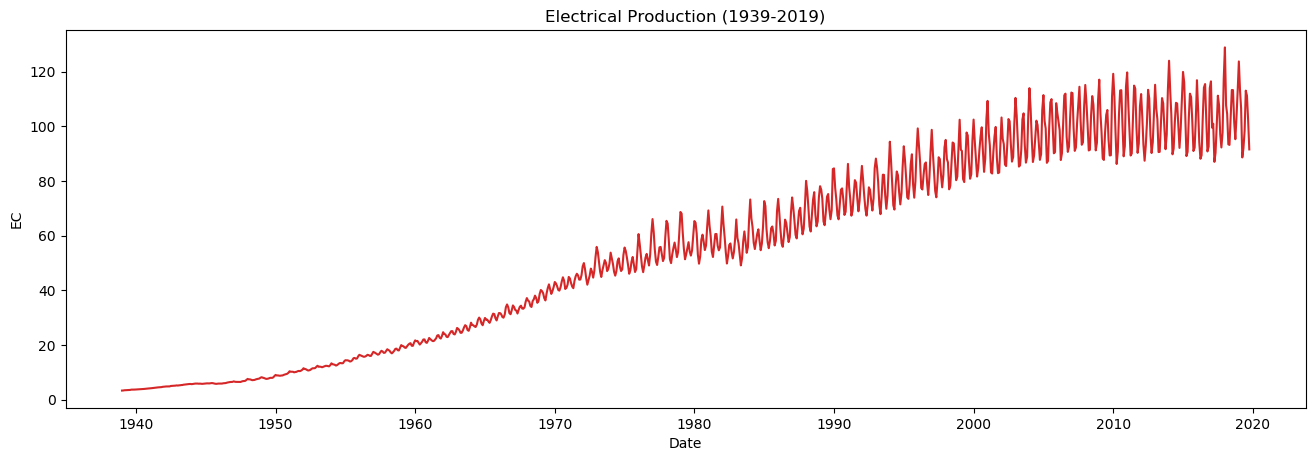

In [7]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='EC', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.EC, title='Electrical Production (1939-2019)')    

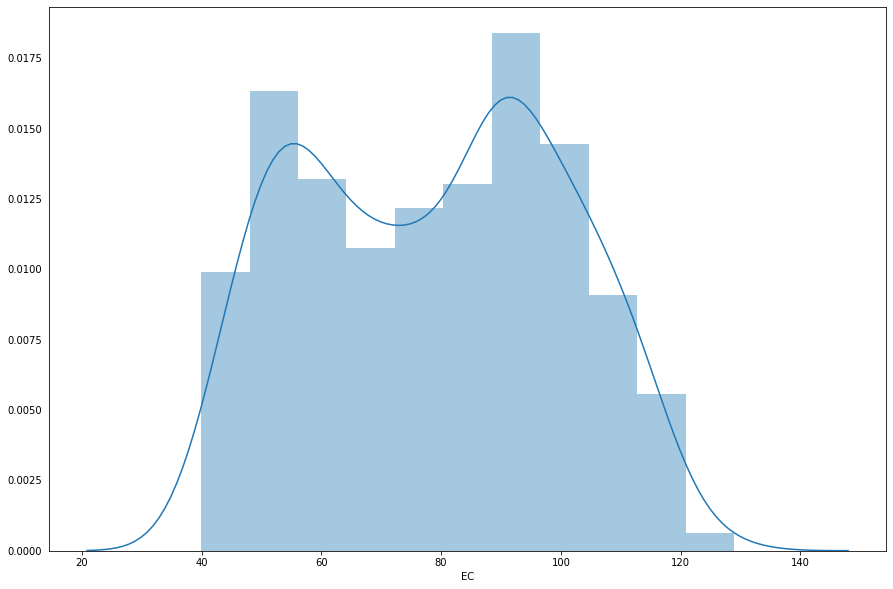

In [67]:
plt.figure(figsize=(15,10))
sns.distplot(df.EC)

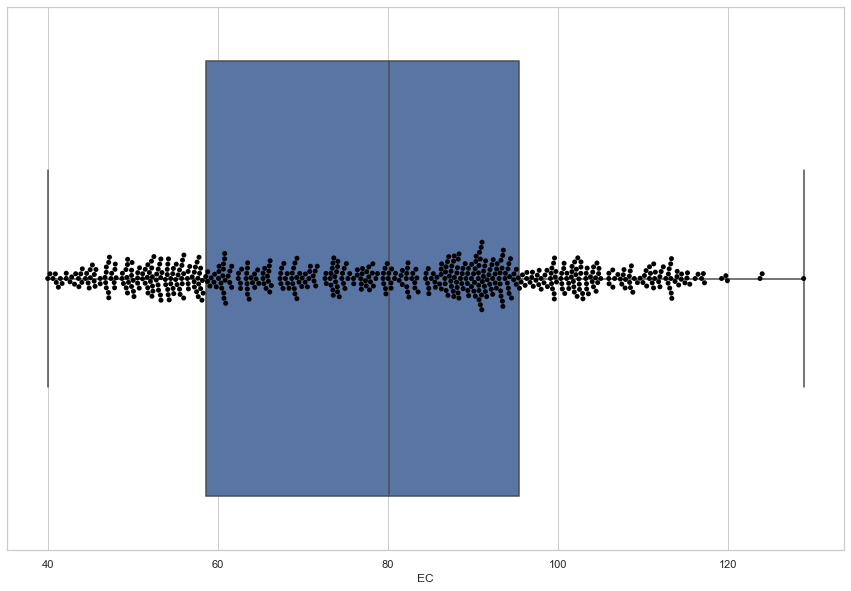

In [68]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid", color_codes='denim blue')
ax = sns.boxplot(x=df["EC"])
ax = sns.swarmplot(x=df["EC"], color='black')

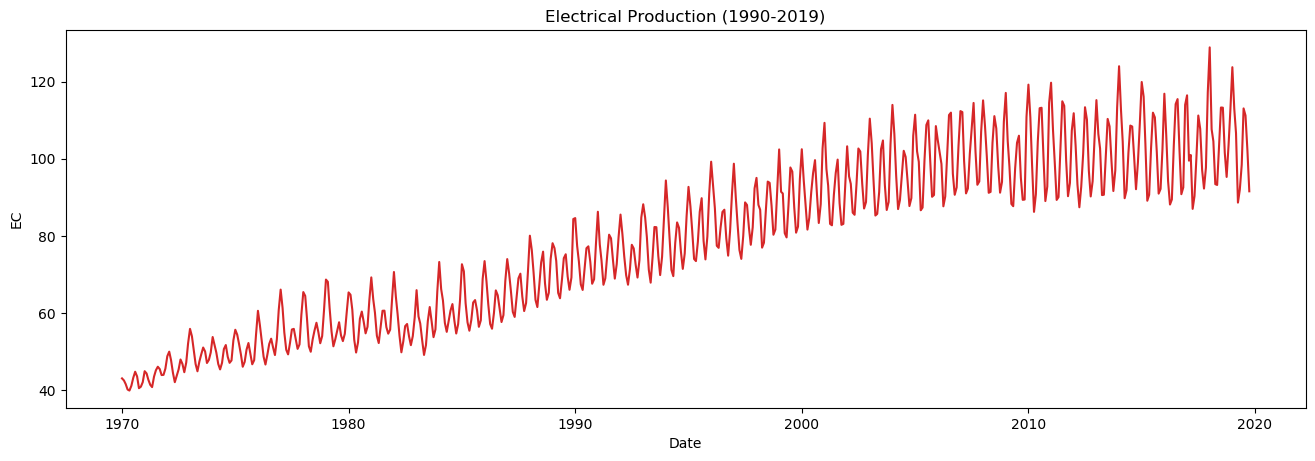

In [8]:
#I think the data is too much. Let's focus on more recent years...
df = df.loc[df.index.year>1969]
plot_df(df, x=df.index, y=df.EC, title='Electrical Production (1990-2019)')    

In [9]:
df.shape

(598, 1)

In [10]:
df.tail(10)

,EC
Date,
2019-01-01,123.7687
2019-02-01,112.9837
2019-03-01,106.6593
2019-04-01,88.6631
2019-05-01,91.9852
2019-06-01,98.4547
2019-07-01,113.0792
2019-08-01,111.2541
2019-09-01,102.1510


In [11]:
#let us select the last 86 observations for testing
train = df[:571]
test = df[571:]

In [14]:
train.tail(10)

,EC
Date,
2016-10-01,90.8499
2016-11-01,92.6032
2016-12-01,114.0219
2017-01-01,116.4746
2017-02-01,99.5393
2017-03-01,101.0063
2017-04-01,87.0374
2017-05-01,90.3591
2017-06-01,100.4412


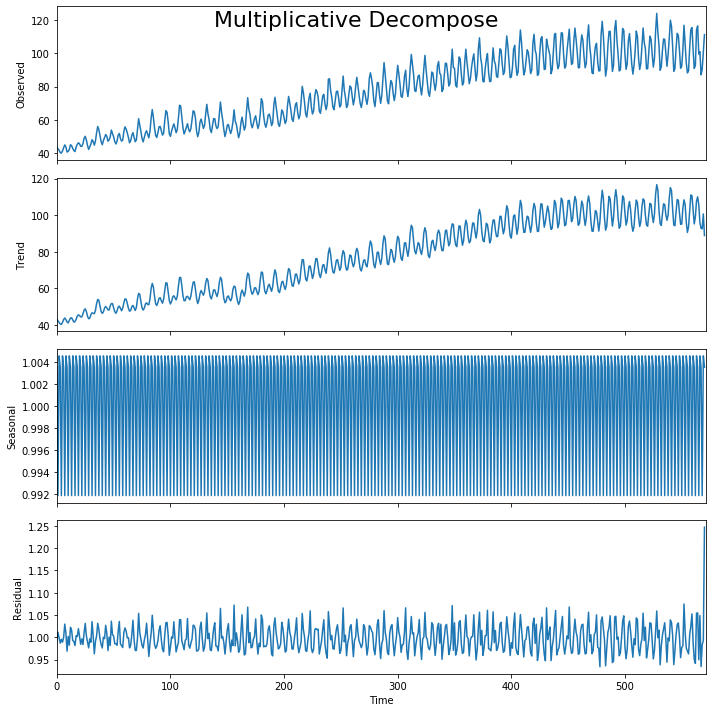

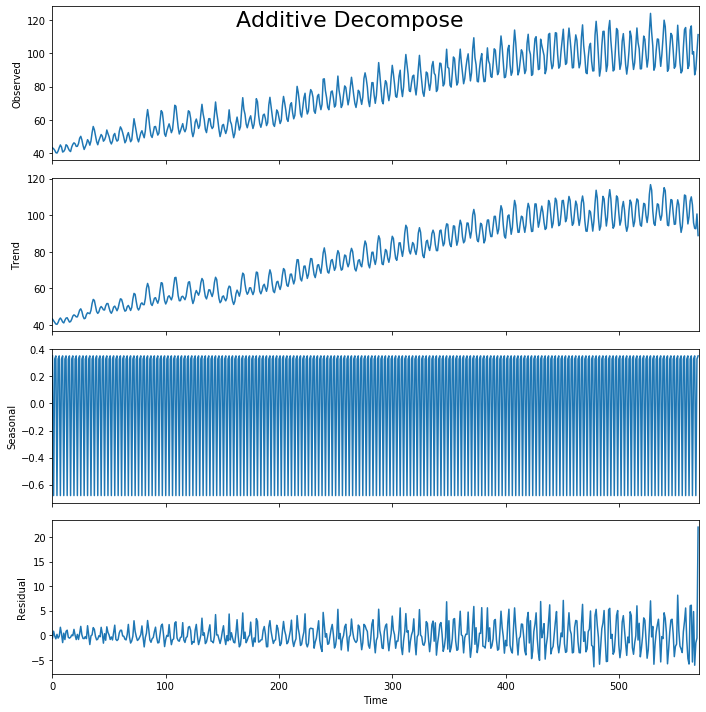

In [15]:
#seasonal decomposition

# Multiplicative Decomposition 
result_mul = seasonal_decompose(np.asarray(train['EC']), model='multiplicative', freq=3, extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(np.asarray(train['EC']), model='additive', freq=3, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
def dickeyFuller(df):
    result = adfuller(df.EC.values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'{key}, {value}')
dickeyFuller(train)

ADF Statistic: -1.7506213519049465
p-value: 0.4052374435661836
Critial Values:
1%, -3.44218748274498
Critial Values:
5%, -2.8667617276005006
Critial Values:
10%, -2.569551011281552


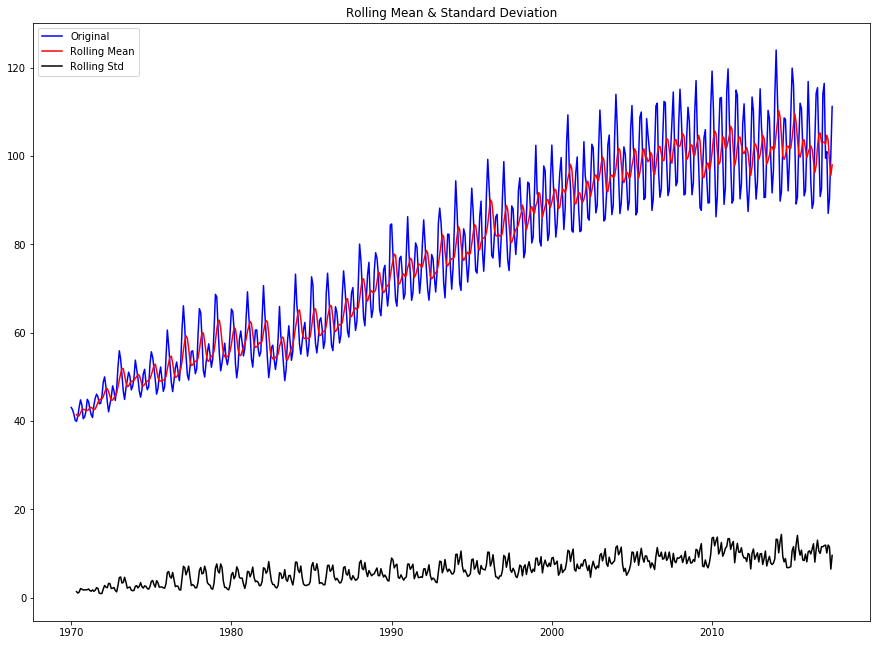

In [17]:
#we can verify this visually also
def rollingGraphs(df):
    rollavg = df.rolling(window=5).mean()
    rollstd = df.rolling(window=5).std()
    plt.figure(figsize=(15,11))
    orig = plt.plot(df, color='blue', label='Original')
    mean = plt.plot(rollavg, color='red', label='Rolling Mean')
    std = plt.plot(rollstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
rollingGraphs(train)

ADF Statistic: -6.446124089787752
p-value: 1.564323554679776e-08
Critial Values:
1%, -3.4423614311926514
Critial Values:
5%, -2.866838307535097
Critial Values:
10%, -2.56959181953083


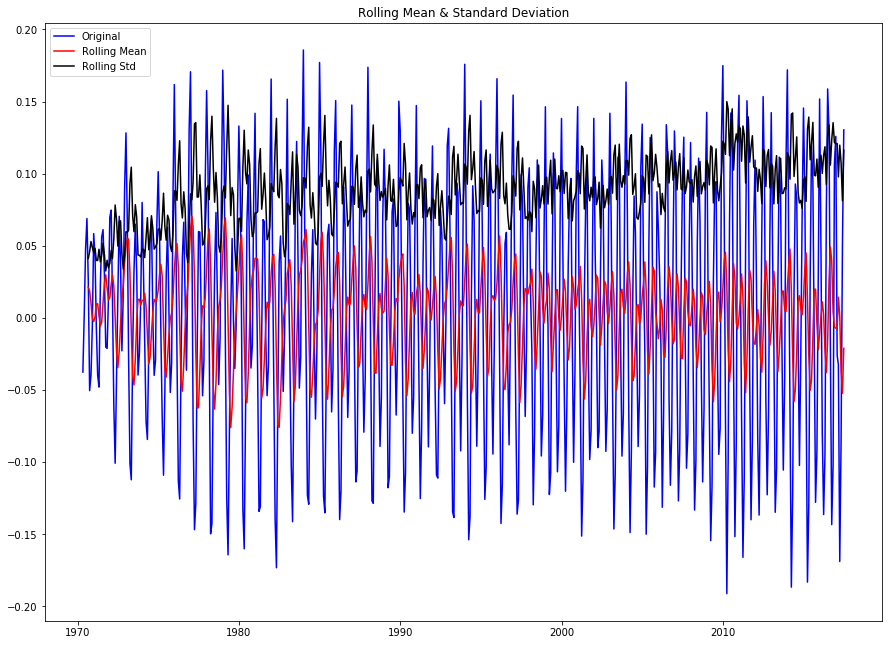

In [18]:
# log differencing
trainlog = np.log(train)
rollavgLog = trainlog.rolling(window=5).mean()
differenced = trainlog - rollavgLog
differenced.dropna(inplace=True)
dickeyFuller(differenced)
rollingGraphs(differenced)

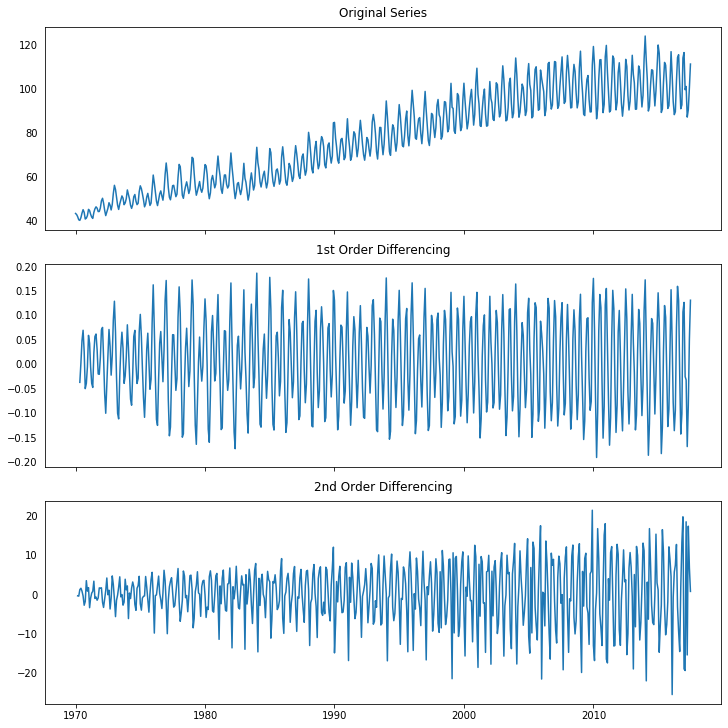

In [64]:
#differencing can also be achieved through diff() function
# Original Series
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].plot(train.EC) 
axes[0].set_title('Original Series')

# 1st Differencing
#differenced = train.EC.diff()
axes[1].plot(differenced) 
axes[1].set_title('1st Order Differencing')
#plot_acf(train.EC.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
differenced2 = train.EC.diff().diff()
differenced2.dropna(inplace=True)
axes[2].plot(differenced2)
axes[2].set_title('2nd Order Differencing')
#plot_acf(train.EC.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

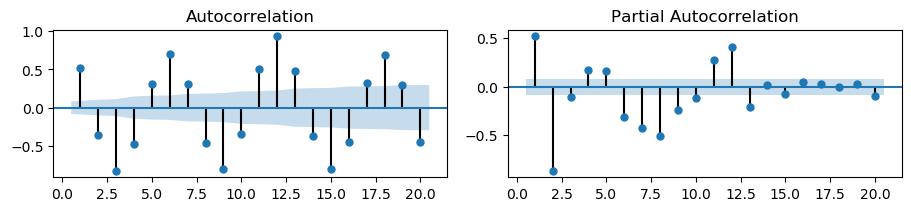

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(9,2),dpi=100, constrained_layout=True)
plt.plot(figure=plot_acf(differenced.EC.tolist(), lags=20, ax=axes[0], zero=False))
plt.plot(figure=plot_pacf(differenced.EC.tolist(), lags=20, ax=axes[1], zero=False))
plt.show()

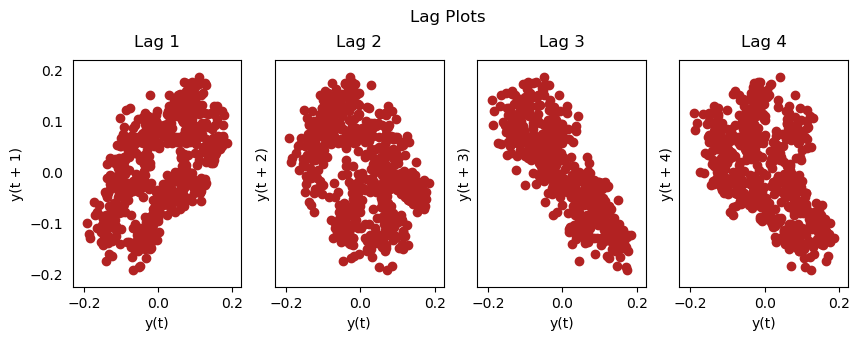

In [21]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(differenced.EC, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots', y=1.05)    
plt.show()

In [22]:
#Approximate Entropy
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(differenced.EC, m=2, r=0.2*np.std(differenced.EC)))

0.9370245277984157


In [23]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(differenced.EC, m=2, r=0.2*np.std(differenced.EC)))

1.0290432143418224


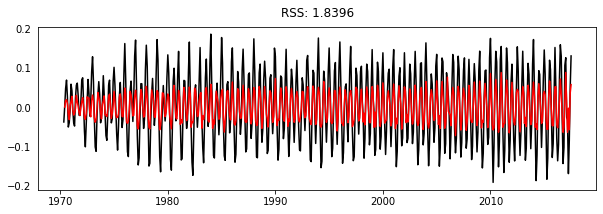

                             ARIMA Model Results                              
Dep. Variable:                   D.EC   No. Observations:                  566
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 644.462
Method:                       css-mle   S.D. of innovations              0.077
Date:                Tue, 10 Dec 2019   AIC                          -1282.924
Time:                        09:37:23   BIC                          -1269.908
Sample:                    06-01-1970   HQIC                         -1277.844
                         - 07-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.006      0.080      0.936      -0.011       0.011
ar.L1.D.EC     0.4221      0.038     11.084      0.000       0.347       0.497
                                    Roots           

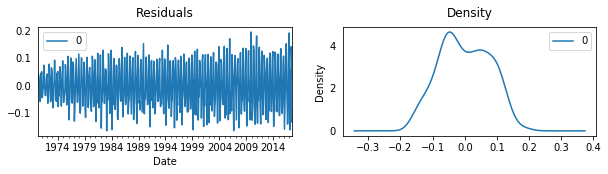

In [66]:
#AR Model (p=1)
model = ARIMA(differenced, order=(1,1,0))
fittedModel = model.fit(disp=-1)
plt.figure(figsize=(10,3))
plt.plot(differenced, color='black')
plt.plot(fittedModel.fittedvalues, color='red')
plt.title('RSS: %.4f'%np.sum((fittedModel.fittedvalues - differenced['EC'])**2))
plt.show()
print(fittedModel.summary())

residuals = pd.DataFrame(fittedModel.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(10,2))
residuals.plot(kind='kde', title='Density', ax=ax[1], figsize=(10,2))
plt.show()

In [49]:
differenced.tail(10)

,EC
Date,
2016-10-01,-0.143306
2016-11-01,-0.102084
2016-12-01,0.106285
2017-01-01,0.125890
2017-02-01,-0.025877
2017-03-01,-0.032442
2017-04-01,-0.168890
2017-05-01,-0.084916
2017-06-01,0.050485


In [77]:
pred = fittedModel.plot_predict(start=pd.to_datetime('2010-01-01'), 
                                end=pd.to_datetime('2017-07-01'), 
                                dynamic=False,
                                plot_insample=True)
plt.show()


AttributeError: 'SARIMAXResults' object has no attribute 'plot_predict'

ADF Statistic: -2.787272510978141
p-value: 0.0601149240301538
Critial Values:
1%, -4.01203360058309
Critial Values:
5%, -3.1041838775510207
Critial Values:
10%, -2.6909873469387753


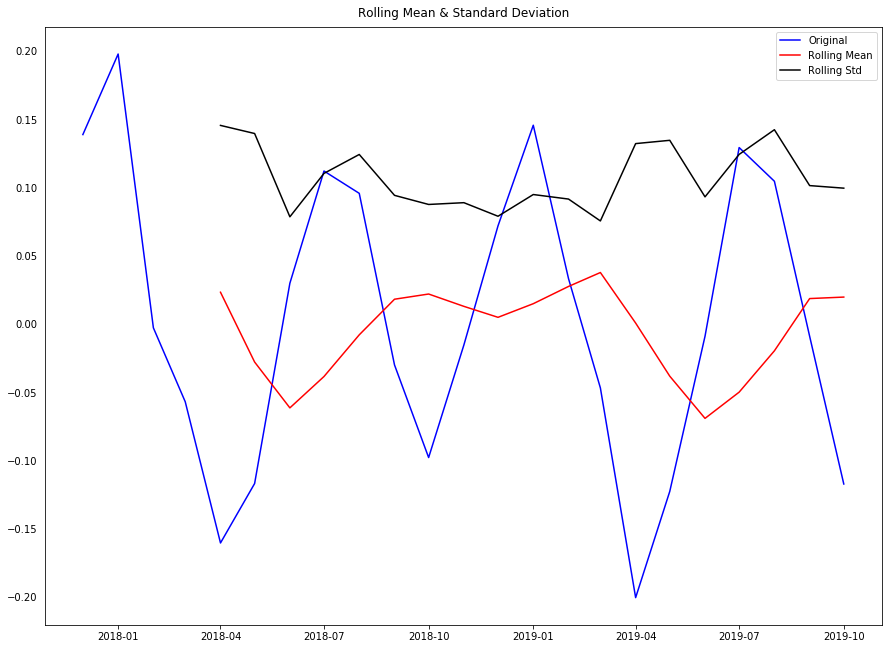

In [55]:
testlog = np.log(test)
rollavgLog = testlog.rolling(window=5).mean()
difftest = testlog - rollavgLog
difftest.dropna(inplace=True)
dickeyFuller(difftest)
rollingGraphs(difftest)

In [56]:
difftest.shape

(23, 1)

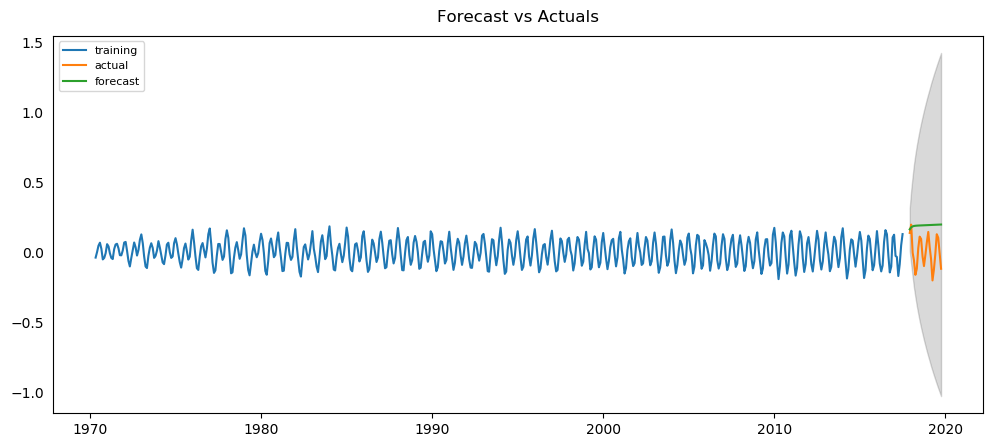

In [57]:
fc, se, conf = fittedModel.forecast(23, alpha=0.05)  # 95% conf

# Make as pandas series
fc = pd.Series(fc, index=difftest.index)
lower = pd.Series(conf[:, 0], index=difftest.index)
upper = pd.Series(conf[:, 1], index=difftest.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(differenced, label='training')
plt.plot(difftest,label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower.index, lower, upper, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()



## SARIMAX

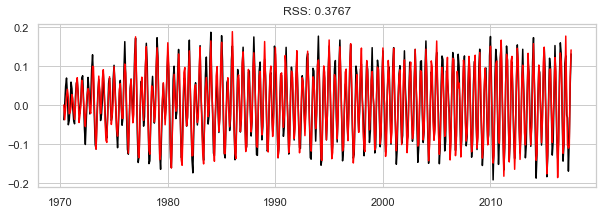

                                 Statespace Model Results                                 
Dep. Variable:                                 EC   No. Observations:                  567
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 12)   Log Likelihood                1268.042
Date:                            Tue, 10 Dec 2019   AIC                          -2528.083
Time:                                    09:54:24   BIC                          -2510.729
Sample:                                05-01-1970   HQIC                         -2521.310
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4243      0.041     10.376      0.000       0.344       0.504
ma.L1         -0.9982      0.044   

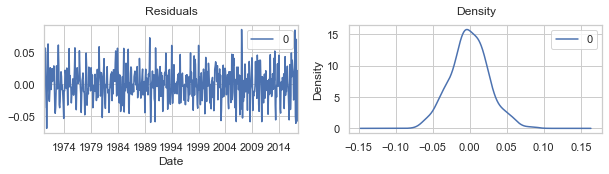

In [76]:
#AR Model (p=1)
model = SARIMAX(differenced, freq='MS', order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
fittedModel = model.fit(disp=False)

plt.figure(figsize=(10,3))
plt.plot(differenced, color='black')
plt.plot(fittedModel.fittedvalues, color='red')
plt.title('RSS: %.4f'%np.sum((fittedModel.fittedvalues - differenced['EC'])**2))
plt.show()
print(fittedModel.summary())

residuals = pd.DataFrame(fittedModel.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], figsize=(10,2))
residuals.plot(kind='kde', title='Density', ax=ax[1], figsize=(10,2))
plt.show()

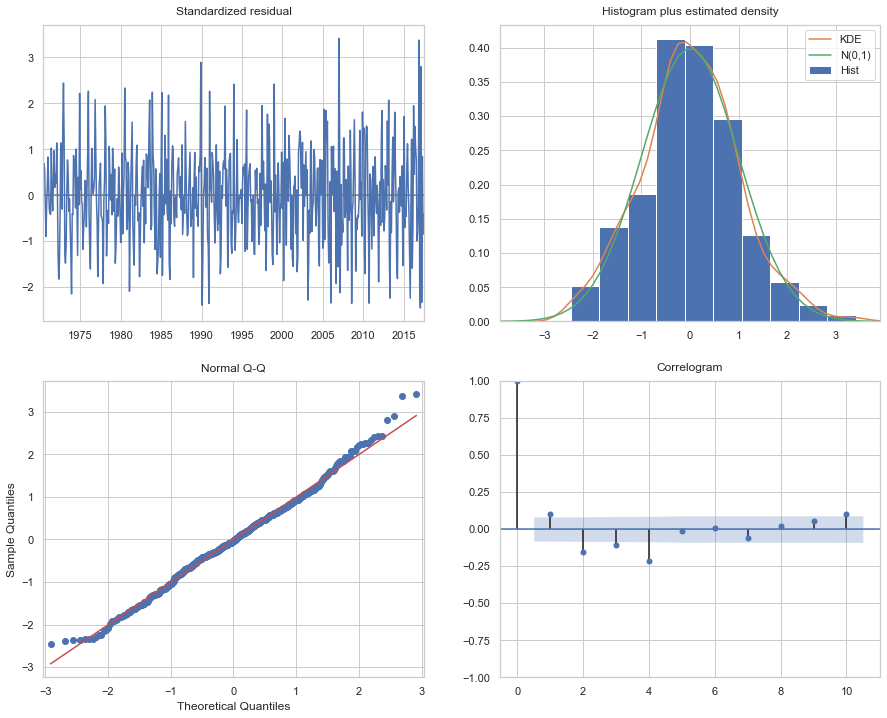

In [78]:
fittedModel.plot_diagnostics(figsize=(15, 12))
plt.show()

In [88]:
pred = fittedModel.get_prediction(start=pd.to_datetime('1971-05-01'), end=pd.to_datetime('2017-07-01'), dynamic=False)
pred_ci = pred.conf_int()

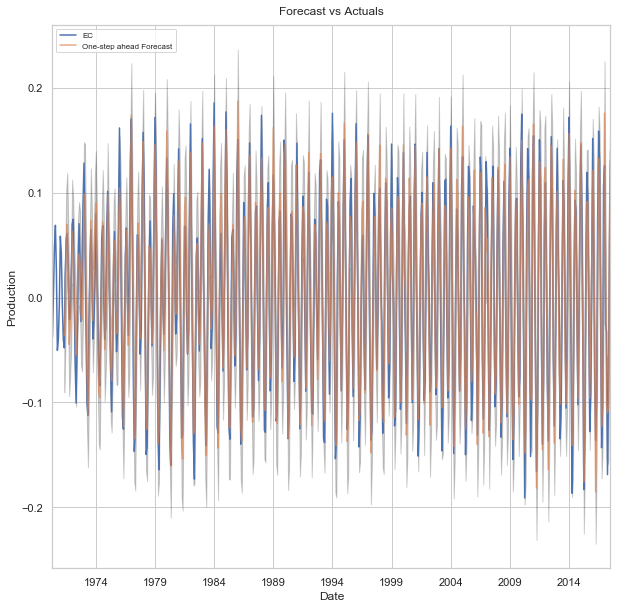

In [89]:
#plt.figure(figsize=(12,5), dpi=100)
#plt.plot(differenced, label='training')
#plt.plot(difftest,label='actual')
#plt.plot(fc, label='forecast')

#ax = y['1990':].plot(label='observed')
ax = differenced.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Production')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.show()

In [91]:
y_forecasted = pred.predicted_mean

# Compute the mean square error
mse = ((y_forecasted - differenced.EC) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [92]:
pred_dynamic = fittedModel.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

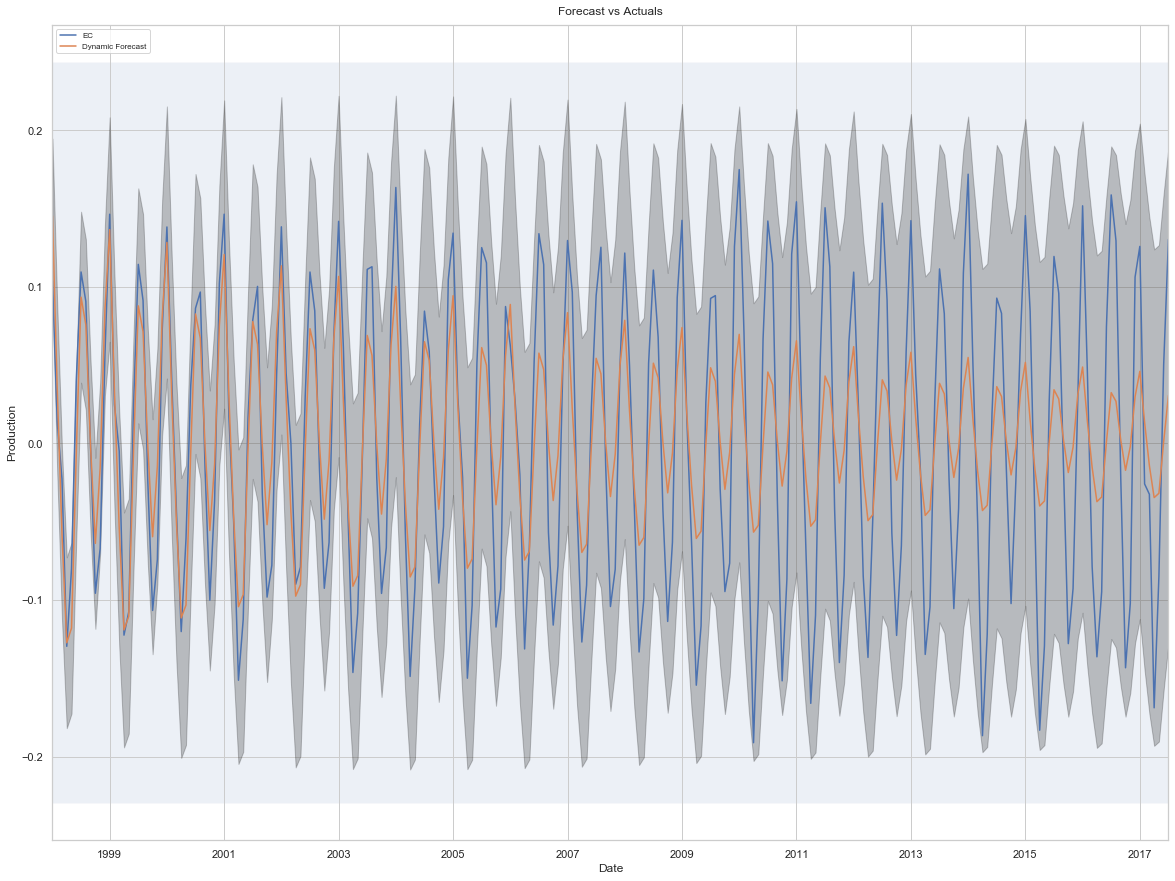

In [97]:
ax = differenced['1998-01-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), differenced.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Production')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [98]:
y_forecasted = pred.predicted_mean
#y_truth = differenced['1971-01-01':]

# Compute the mean square error
mse = ((y_forecasted - differenced.EC) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [101]:
pred_uc = fittedModel.get_forecast(steps=500)
pred_ci = pred_uc.conf_int()

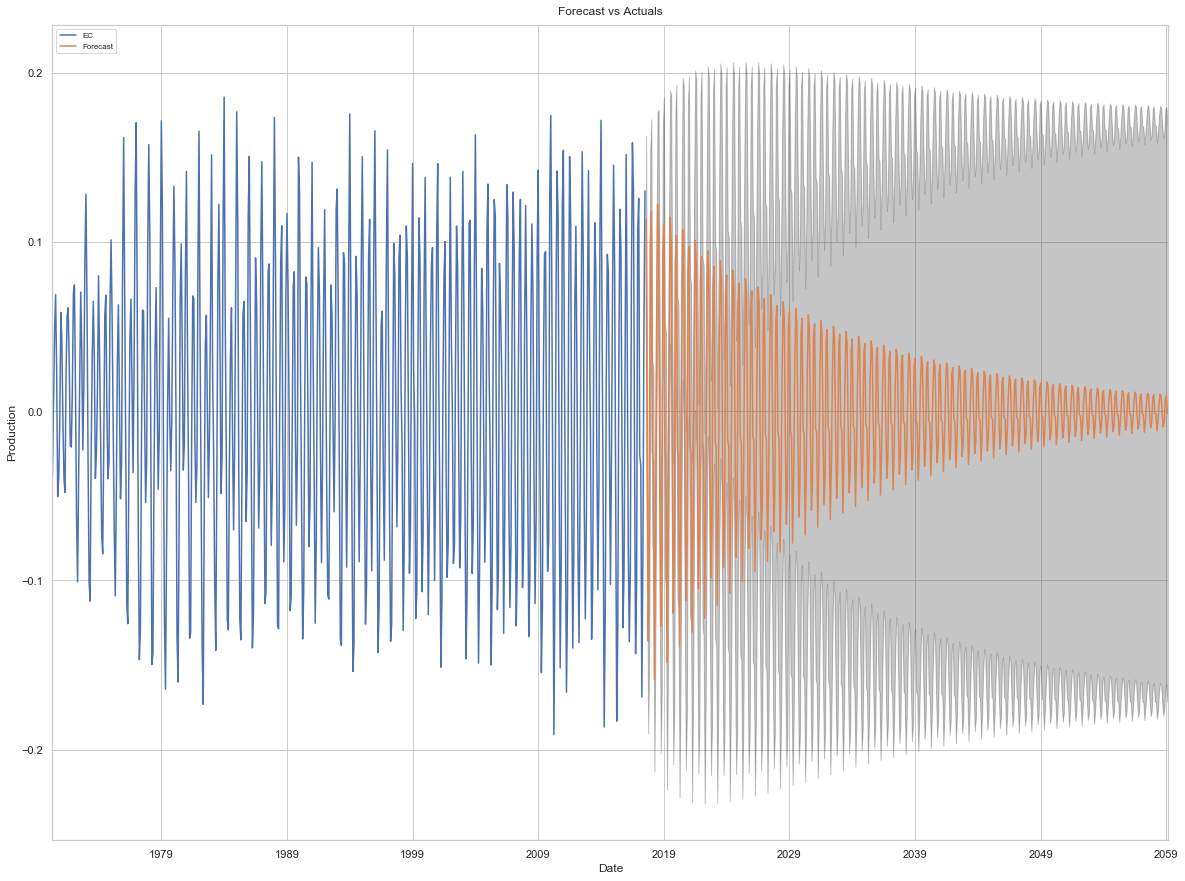

In [102]:
ax = differenced.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Production')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Code to deal with missing values (if any)

In [ ]:

from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
df_orig = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date').head(100)
df = pd.read_csv('a10missing.csv', parse_dates=['date'], index_col='date').head(100)

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Available Data", "Missing Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

# ## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

# ## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

# ## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")

In [ ]:
data.index = pd.to_datetime(data.index)

In [ ]:
data.columns = ['Energy Production']

In [ ]:
plot_df(data, x=data.index, y=data.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')    